In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from torchvision.transforms.functional import to_pil_image

In [93]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=4, feature_maps=64):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=z_dim, 
                out_channels=feature_maps*8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(num_features=feature_maps*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=feature_maps*8,
                out_channels=feature_maps*4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=feature_maps*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=feature_maps*4,
                out_channels=feature_maps*2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=feature_maps*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=feature_maps*2,
                out_channels=feature_maps,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=feature_maps),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=feature_maps,
                out_channels=feature_maps,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(num_features=feature_maps),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(
                in_channels=feature_maps, 
                out_channels=img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z)
        

class Critic(nn.Module):
    def __init__(self, img_channels=4, feature_maps=64):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(
                in_channels=img_channels,
                out_channels=feature_maps,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=feature_maps,
                out_channels=feature_maps*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=feature_maps*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=feature_maps*2, 
                out_channels=feature_maps*4, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            nn.BatchNorm2d(num_features=feature_maps*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=feature_maps*4, 
                out_channels=feature_maps*8, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            nn.BatchNorm2d(num_features=feature_maps*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(
                in_channels=feature_maps*8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0
            ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            # nn.Conv2d(512, 1, 1)
        )

    def forward(self, x):
        return self.critic(x).view(-1)

In [3]:
# testlayer = nn.AdaptiveAvgPool2d(output_size=(1, 1))
# testinput = torch.rand(16, 4, 5, 5)
# testinput

In [94]:
def gradient_penalty(critic, real, fake, device):
    batch_size, c, h, w = real.shape
    alpha = torch.rand(batch_size, 1, 1, 1, device=device).expand_as(real)
    interpolated = alpha * real + (1 - alpha) * fake
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated)

    grad_outputs = torch.ones_like(mixed_scores)
    gradients = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)
    gp = ((grad_norm - 1)**2).mean()
    return gp

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

z_dim = 128
lr = 1e-4
batch_size = 64
image_size = 64
img_channels= 4
n_critic = 5
lambda_gp = 10
epochs = 50

In [96]:

path = r'no-gif-images\1 - bulbasaur\sprites_bank_normal_bulbasaur.png'
with open(path, 'rb') as f:
    img = Image.open(f)
    img.convert('RGBA')
    img = np.array(img)
    print(img)
    print(img.max(), img.min(), img.mean())
    print(img.shape)
    plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
231 0 9.40155029296875
(128, 128)


torch.Size([4, 128, 128])


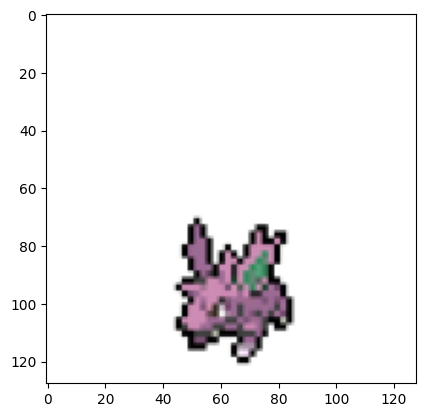

torch.Size([4, 128, 128])


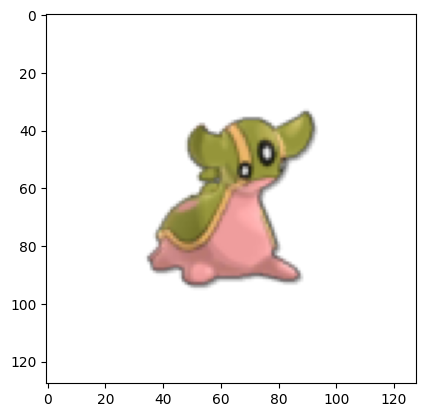

torch.Size([4, 128, 128])


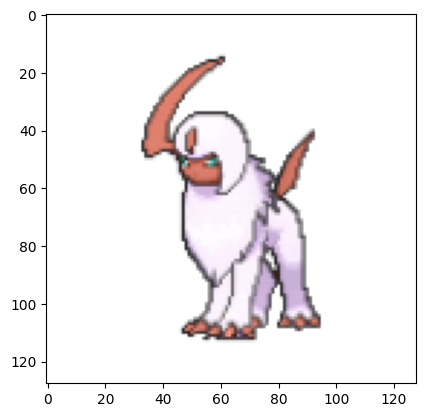

torch.Size([4, 128, 128])


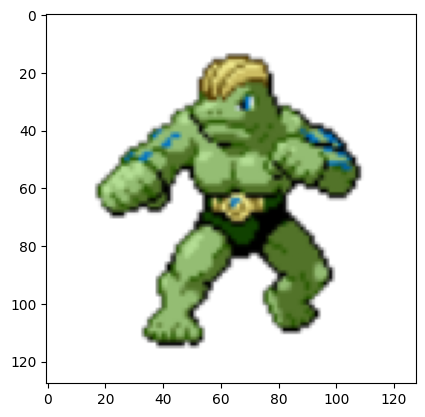

torch.Size([4, 128, 128])


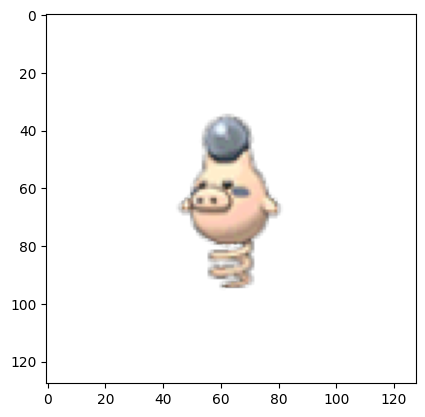

In [97]:
gen = Generator(z_dim, img_channels).to(device)
critic = Critic(img_channels).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

def rgba_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGBA')


transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((128, 128)),
    transforms.ToDtype(torch.float32),
    transforms.Lambda(lambda x: x/255.0)
])

root_dir = 'no-gif-images/'
dataset = datasets.ImageFolder(root=root_dir, 
                               transform=transform, 
                               loader=rgba_loader)
loader = DataLoader(dataset, 
                    batch_size=batch_size, 
                    shuffle=True)

i = 0
for images, _ in loader:
    print(images[0].shape)
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    i += 1
    if i == 5:
        break

In [111]:
critic_loss = []
gen_loss = []

fixed_random = torch.randn(16, z_dim, 1, 1, device=device)

for epoch in range(epochs):
    print(f'Epoch # {epoch+1}\n')
    for i, (real, _) in enumerate(loader):
        print(f'Training batch # {i+1}')
        real = real.to(device)
        cur_batch_size = real.size(0)

        for j in range(n_critic):
            noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
            fake = gen(noise)
            critic_real = critic(real)
            critic_fake = critic(fake)
            gp = gradient_penalty(critic, real, fake, device)

            loss_critic = -(critic_real.mean() - critic_fake.mean()) + lambda_gp * gp
            opt_critic.zero_grad()
            loss_critic.backward()
            opt_critic.step()

        noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake = gen(noise)
        loss_gen = -critic(fake).mean()
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f'Epoch [{epoch+1}/epochs] Loss D: {loss_critic.item():.4f} Loss G: {loss_gen.item():.4f}')
    with torch.no_grad():
        fake = gen(fixed_random)
        # save_image(fake, f"fake_images/fake_{epoch+1}.png", normalize=True)
        grid = make_grid(fake, nrow=4, normalize=True, scale_each=True)
        pil_img = to_pil_image(grid, mode='RGBA')
        pil_img = pil_img.resize((1000, 1000))
        pil_img.save(f"fake_images/fake/fake_{epoch+1}.png")

        grid = make_grid(real[:16], nrow=4, normalize=True, scale_each=True)
        pil_img = to_pil_image(grid, mode='RGBA')
        pil_img = pil_img.resize((1000, 1000))
        pil_img.save(f"fake_images/real/real_{epoch+1}.png")

    critic_loss.append(loss_critic.item())
    gen_loss.append(loss_gen.item())

Epoch # 1

Training batch # 1
Training batch # 2
Training batch # 3
Training batch # 4
Training batch # 5
Training batch # 6
Training batch # 7
Training batch # 8
Training batch # 9
Training batch # 10
Training batch # 11
Training batch # 12
Training batch # 13
Training batch # 14
Training batch # 15
Training batch # 16
Training batch # 17
Training batch # 18
Training batch # 19
Training batch # 20
Training batch # 21
Training batch # 22
Training batch # 23
Training batch # 24
Training batch # 25
Training batch # 26
Training batch # 27
Training batch # 28
Training batch # 29
Training batch # 30
Training batch # 31
Training batch # 32
Training batch # 33
Training batch # 34
Training batch # 35
Training batch # 36
Training batch # 37
Training batch # 38
Training batch # 39
Training batch # 40
Training batch # 41
Training batch # 42
Training batch # 43
Training batch # 44
Training batch # 45
Training batch # 46
Training batch # 47
Training batch # 48
Training batch # 49
Training batch # 5

KeyboardInterrupt: 

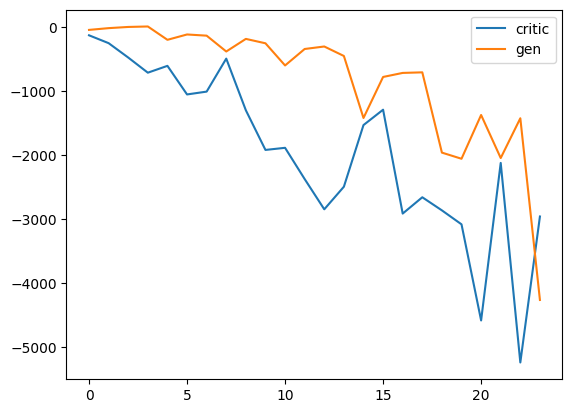

In [47]:
plt.plot(critic_loss, label='critic')
plt.plot(gen_loss, label='gen')
plt.legend()

In [49]:
torch.save(gen.state_dict(), 'gen.pth')
torch.save(critic.state_dict(), 'critic.pth')

torch.save(opt_gen.state_dict(), 'opt_gen.pth')
torch.save(opt_critic.state_dict(), 'opt_critic.pth')

In [50]:
checkpoint = {
    'gen': gen.state_dict(),
    'critic': critic.state_dict(),
    'opt_gen': opt_gen.state_dict(),
    'opt_critic': opt_critic.state_dict(),
    'epoch': epoch,
    'gen_loss': gen_loss,
    'critic_loss': critic_loss
}
torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
# fake = gen(torch.randn(16, z_dim, 1, 1, device=device))
# save_image(fake, f"fake_images/test.png", normalize=True)

In [ ]:

# grid = make_grid(fake, nrow=4, normalize=True, scale_each=True)
# pil_img = to_pil_image(grid, mode='RGBA')
# pil_img = pil_img.resize((1000, 1000))
# pil_img.save("fake_images/test1.png")

In [89]:
pil_img = to_pil_image(real[0])  # explicitly set mode
pil_img = pil_img.resize((1000, 1000))
pil_img.save("fake_images/true_test.png")